In [45]:
import numpy as np
import pandas as pd

df = pd.read_csv("../billboard_hot_100_sentiment.csv")
df.dtypes

title                 object
artist                object
lyrics                object
rank                   int64
last_week              int64
peak_rank              int64
weeks_on_chart         int64
release_year           int64
lyric_length           int64
word_count             int64
top_emotion           object
top_emotion_score    float64
anger                float64
disgust              float64
fear                 float64
joy                  float64
neutral              float64
sadness              float64
surprise             float64
dtype: object

In [46]:
print(f"Dataset: {df.shape[0]} songs, {df.shape[1]} columns")
df.head()

Dataset: 99 songs, 19 columns


,title,artist,lyrics,rank,last_week,peak_rank,weeks_on_chart,release_year,lyric_length,word_count,top_emotion,top_emotion_score,anger,disgust,fear,joy,neutral,sadness,surprise
0,Ordinary,Alex Warren,"They say, ""The holy water's watered down And t...",1,1,1,25,2025,356,352,sadness,0.354639,0.079038,0.093723,0.091241,0.036207,0.134498,0.354639,0.210655
1,Golden,"HUNTR/X: EJAE, Audrey Nuna & REI AMI","I was a ghost, I was alone 어두워진 앞길속에 (Hah) Giv...",2,2,2,6,2025,345,304,fear,0.383440,0.063155,0.013784,0.383440,0.026303,0.099525,0.206061,0.207732
2,What I Want,Morgan Wallen Featuring Tate McRae,"She said, ""You don't want this heart, boy, it'...",3,4,1,11,2025,433,428,anger,0.451607,0.451607,0.059232,0.230261,0.021143,0.129680,0.091698,0.016379
3,Daisies,Justin Bieber,"Throwin' petals like, ""Do you love me or not?""...",4,3,2,3,2025,341,336,neutral,0.433261,0.324150,0.110138,0.069871,0.014375,0.433261,0.031724,0.016482
4,Just In Case,Morgan Wallen,I ain't sayin' that I always sleep alone I ain...,5,5,2,19,2025,391,386,sadness,0.442795,0.040187,0.021925,0.038544,0.044610,0.391176,0.442795,0.020762


In [47]:
# Sentiment features
df['negative_emotions'] = df['anger'] + df['disgust'] + df['fear'] + df['sadness']
df['positive_emotions'] = df['joy'] + df['surprise']
df['emotion_ratio'] = df['positive_emotions'] / (df['negative_emotions'] + 0.01)
df['sentiment_spread'] = df[['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']].std(axis=1)
df['emotion_intensity'] = df[['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']].max(axis=1)

# Text complexity features
df['avg_word_length'] = df['lyric_length'] / (df['word_count'] + 1)
df['words_per_100_chars'] = (df['word_count'] / df['lyric_length']) * 100

# Sentiment dominance (is one emotion overwhelming?)
df['dominant_emotion_strength'] = df['top_emotion_score']
df['is_neutral_dominant'] = (df['neutral'] > 0.5).astype(int)

# Emotional balance
df['joy_sadness_diff'] = df['joy'] - df['sadness']
df['anger_fear_diff'] = df['anger'] - df['fear']

# Song era (only time-based feature we'll keep)
df['song_age'] = 2025 - df['release_year']
df['is_recent'] = (df['release_year'] >= 2020).astype(int)

print("✓ Lyrics-based features created")

✓ Lyrics-based features created


In [48]:
# Select ONLY lyrics and sentiment features
feature_cols = [
    # Core sentiment scores
    'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise',
    'top_emotion_score', 'dominant_emotion_strength',
    
    # Derived sentiment features
    'negative_emotions', 'positive_emotions', 'emotion_ratio', 
    'sentiment_spread', 'emotion_intensity', 'is_neutral_dominant',
    'joy_sadness_diff', 'anger_fear_diff',
    
    # Text features
    'lyric_length', 'word_count', 'avg_word_length', 'words_per_100_chars',
    
    # Time features
    'release_year', 'song_age', 'is_recent'
]

# Clean data
df_clean = df.dropna(subset=feature_cols + ['rank'])
X = df_clean[feature_cols]
y = df_clean['rank']

print(f"\nUsing {len(feature_cols)} lyrics-based features")
print(f"Total samples: {len(X)}")
print("\n✓ NO chart performance data used (avoiding data leakage)")


Using 24 lyrics-based features
Total samples: 99

✓ NO chart performance data used (avoiding data leakage)


In [49]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training: {len(X_train)} | Testing: {len(X_test)}")

Training: 79 | Testing: 20


In [50]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
print("✓ Model trained")

✓ Model trained


In [51]:
y_pred = rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MODEL PERFORMANCE")
print("="*50)
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")
print("="*50)
print(f"\nInterpretation: The model explains {r2*100:.1f}% of variance")
print(f"in rankings using ONLY lyrics and sentiment.")

MODEL PERFORMANCE
RMSE: 32.63
MAE:  28.73
R²:   -0.1064

Interpretation: The model explains -10.6% of variance
in rankings using ONLY lyrics and sentiment.


In [52]:
cv_scores = cross_val_score(
    rf_model, X_train, y_train, 
    cv=5, 
    scoring='neg_mean_squared_error'
)
cv_rmse = np.sqrt(-cv_scores)

print(f"\n5-Fold CV RMSE: {cv_rmse.mean():.2f} (+/- {cv_rmse.std():.2f})")


5-Fold CV RMSE: 31.72 (+/- 1.89)


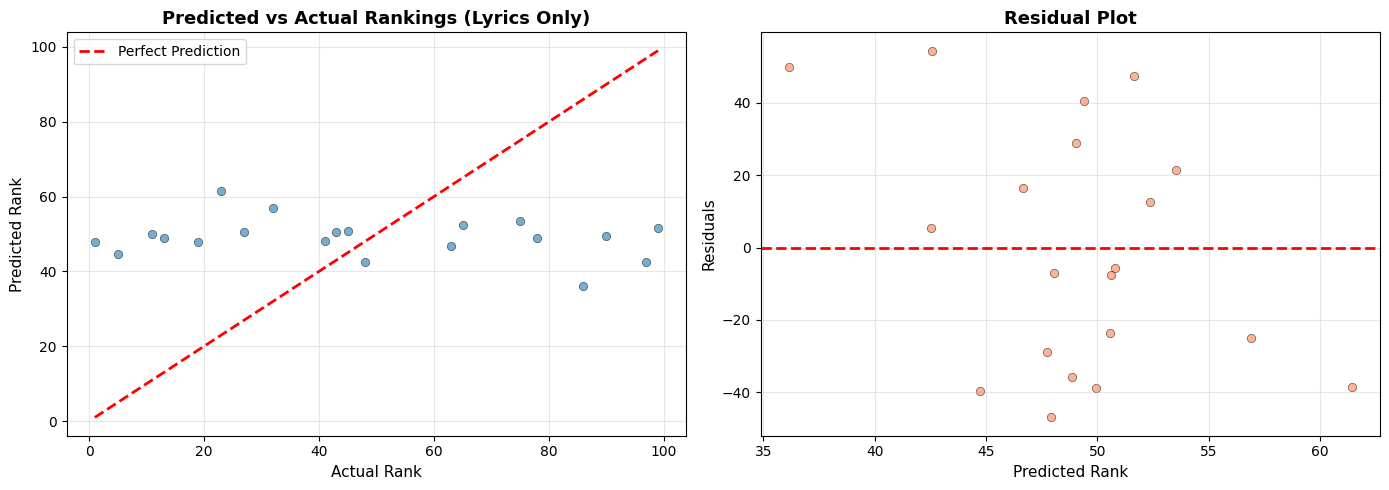

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y_test, y_pred, alpha=0.6, edgecolor='black', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Rank', fontsize=11)
axes[0].set_ylabel('Predicted Rank', fontsize=11)
axes[0].set_title('Predicted vs Actual Rankings (Lyrics Only)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.6, color='coral', edgecolor='black', linewidth=0.5)
axes[1].axhline(y=0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Rank', fontsize=11)
axes[1].set_ylabel('Residuals', fontsize=11)
axes[1].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rf_predictions_lyrics_only.png', dpi=300, bbox_inches='tight')
plt.show()


Top 10 Most Predictive Features:
            Feature  Importance
            disgust    0.094737
       lyric_length    0.084394
words_per_100_chars    0.071399
  emotion_intensity    0.070066
           surprise    0.066146
                joy    0.056638
    avg_word_length    0.056291
               fear    0.054838
    anger_fear_diff    0.047701
         word_count    0.047382


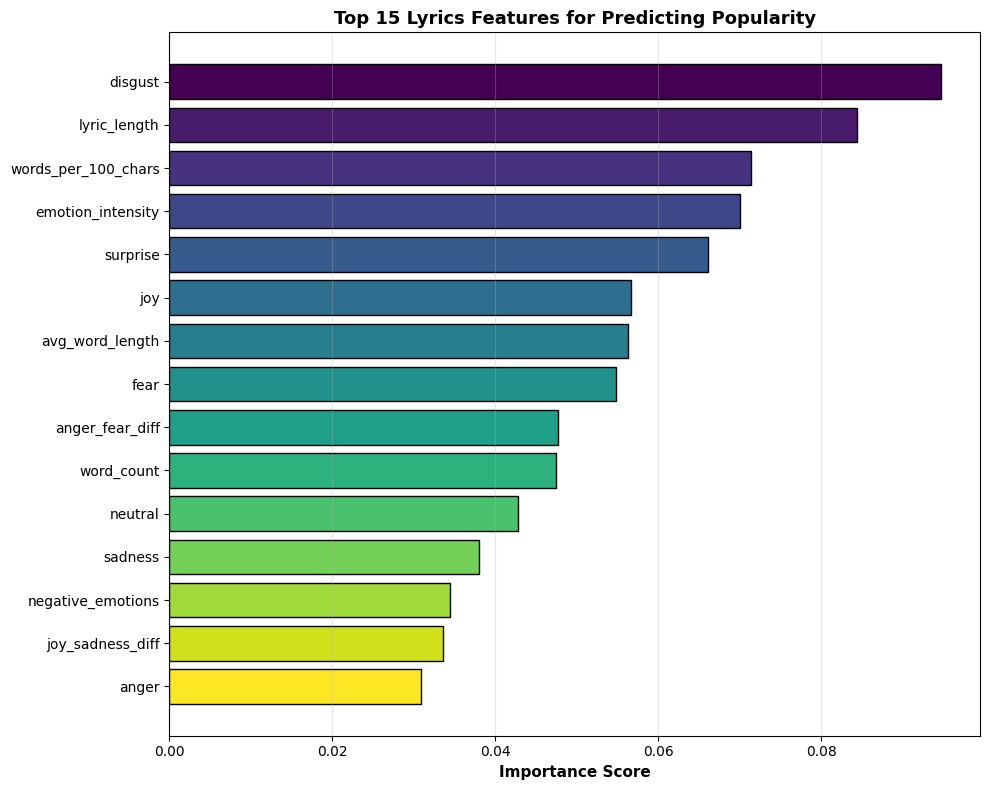

In [54]:
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Predictive Features:")
print(feature_importance.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_15 = feature_importance.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_15)))

plt.barh(top_15['Feature'], top_15['Importance'], color=colors, edgecolor='black')
plt.xlabel('Importance Score', fontsize=11, fontweight='bold')
plt.title('Top 15 Lyrics Features for Predicting Popularity', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance_lyrics.png', dpi=300, bbox_inches='tight')
plt.show()

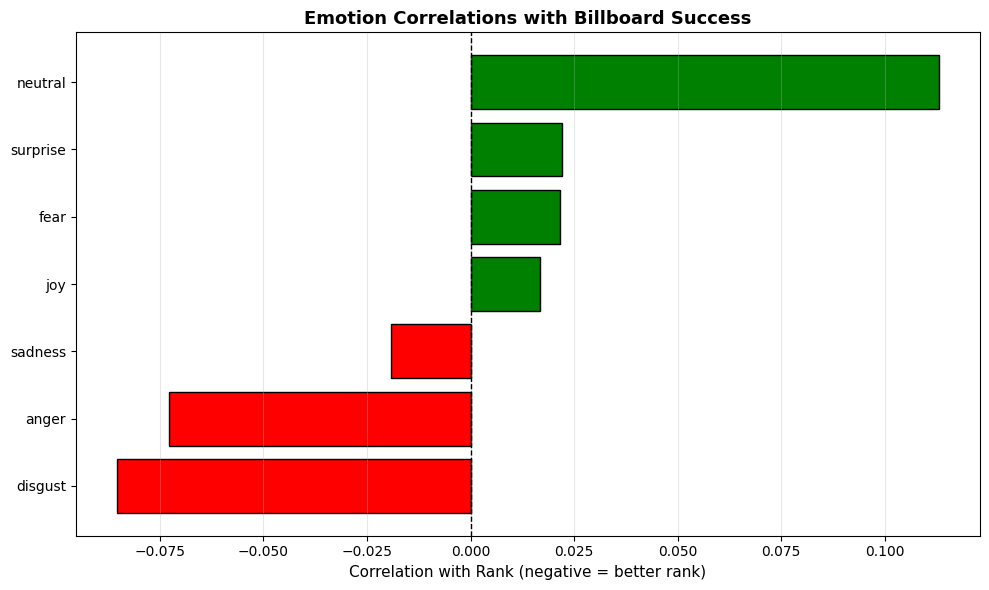


Emotion Correlations with Rank:
(Negative correlation = emotion associated with better rankings)
disgust    -0.085384
anger      -0.072903
sadness    -0.019285
joy         0.016805
fear        0.021492
surprise    0.022062
neutral     0.113071


In [55]:
# Analyze emotion correlations with ranking
emotion_cols = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
correlations = df_clean[emotion_cols + ['rank']].corr()['rank'].drop('rank').sort_values()

plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in correlations.values]
plt.barh(correlations.index, correlations.values, color=colors, edgecolor='black')
plt.xlabel('Correlation with Rank (negative = better rank)', fontsize=11)
plt.title('Emotion Correlations with Billboard Success', fontsize=13, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nEmotion Correlations with Rank:")
print("(Negative correlation = emotion associated with better rankings)")
print(correlations.to_string())


In [56]:
sample_indices = np.random.choice(len(X_test), 8, replace=False)
samples = pd.DataFrame({
    'Actual': y_test.iloc[sample_indices].values,
    'Predicted': y_pred[sample_indices].astype(int),
    'Error': (y_test.iloc[sample_indices].values - y_pred[sample_indices]).round(1)
})

print("\nSample Predictions:")
print(samples.to_string(index=False))


Sample Predictions:
 Actual  Predicted  Error
     11         49  -38.9
     97         42   54.4
     75         53   21.5
     23         61  -38.4
     65         52   12.6
     41         48   -7.1
     43         50   -7.6
     19         47  -28.8
